# Libs

In [1]:
library(GEOquery)
library(matrixStats)
library(genefilter)
library(limma)
library(edgeR)
library(lumi)
library(statmod)
library(org.Hs.eg.db)
library(org.Mm.eg.db)
library(preprocessCore)
library(rgl)
library(mogene10sttranscriptcluster.db)

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with


# Functions

In [4]:
#This script performs preprocessing of dataset and analysis of differentially expressed genes 
#(using limma or edgeR)

Dataset_DEG_analysis <- function(sample_eset,phenodata,
                                 group_col="Group", 
                                 control_group,
                                 batch_col="",
                                 Entrez=T,
                                 type="microarray",
                                 function_path="D:/Documents/Science/PhD/Functions/"){
    
    library(matrixStats)
    library(genefilter)
    
  dataset_results <- list()
  
    if(type=="microarray"){
        if (Entrez==T){
        #1. Transform to Entrez
        data_Entrez <- sample_eset[fData(sample_eset)[,grepl("entrez",tolower(colnames(fData(sample_eset))))]!="" & !is.na(fData(sample_eset)[,grepl("entrez",tolower(colnames(fData(sample_eset))))]),]
        print(paste0("There were ", nrow(sample_eset)," probes"))
        print(paste0("There are ", nrow(data_Entrez)," probes with Entrez IDs"))

        source(paste0(function_path,"FUN.Microarray_to_Entrez.R"))
        source(paste0(function_path,"FUN.Microarray_dictionary_create.R"))

        dictionary_output <- Microarray_dictionary_create(data_Entrez)
        data_Entrez <- Microarray_to_Entrez(dictionary_output$dataset,dictionary_output$dataset_Entreztoprobe,dictionary_output$dataset_probetoEntrez)
        }else{
          data_Entrez <- sample_eset
        }


    #2. Calculate DEG using limma
    source(paste0(function_path,"FUN.Run_limma_for_dataset.R"))

    output <- Run_limma_for_dataset(data_Entrez,phenodata = phenodata,
                                    control_group=control_group,
                                    batch_col=batch_col)

  }else if(type=="RNAseq"){
      #0. RLE normalization
    source(paste0(function_path,"FUN.RLE_normalization.R"))
    data_RLE <- RLE_normalization(sample_eset)
    #plot(density(log2(exprs(data_RLE)+1)[,1]))
    #for (i in 2:ncol(data_RLE)){
    #  lines(density(log2(exprs(data_RLE)+1)[,i]),col=i)
    #}
    
    if (Entrez==T){
      #1. Transform to Entrez
      source(paste0(function_path,"FUN.Ensembl_mouse_dictionary_create.R"))
      source(paste0(function_path,"FUN.Ensembl_to_entrez.R"))
      EntreztoID_rnaseq <- Ensembl_mouse_dictionary_create(sample_eset)
      data_Entrez <- Ensembl_to_entrez(sample_eset,EntreztoID_rnaseq)
      data_Entrez <- new("ExpressionSet", exprs=data_Entrez,phenoData=phenoData(sample_eset))
      #data_RLE_Entrez <- Ensembl_to_entrez(data_RLE,EntreztoID_rnaseq)
      #data_RLE_Entrez <- new("ExpressionSet", exprs=data_RLE_Entrez,phenoData=phenoData(sample_eset))
      
      print(paste0("There were ", nrow(sample_eset)," probes"))
      print(paste0("There are ", nrow(data_Entrez)," probes with Entrez IDs"))
      
    }else{
      data_Entrez <- sample_eset
      data_RLE_Entrez <- data_RLE
    }

    gene_list <- rownames(data_Entrez)

    #2. Calculate DEG using edgeR
    source(paste0(function_path,"FUN.Run_edgeR_for_dataset.R"))
    source(paste0(function_path,"FUN.Run_edgeR.R"))
    library(edgeR)
    library(statmod)

    output <- Run_edgeR_for_dataset(data_Entrez,phenodata = phenodata,
                                    control_group=control_group,
                                    batch_col=batch_col)
    
  }else{
    print("Unknown type of data provided")
    stop()
  }
  
  return(output)
}



In [5]:
#This function creates human dictionary for Ensembl-Entrez mapping
Ensembl_human_dictionary_create <- function(dataset){
        #1) First let's create table where every Ensembl has corresponding Entrez ID; we will remove samples that do not map or map to several Entrez IDs
        library(org.Hs.eg.db)
        rownames(dataset) <- sapply(as.character(rownames(dataset)),function(x){strsplit(x,"[.]")[[1]][1]})
        xx <- as.list(org.Hs.egENSEMBL2EG)
        ensembltoentrez <- data.frame(ID=rownames(dataset),ENTREZID=NA)
        rownames(ensembltoentrez) <- ensembltoentrez$ID
        head(ensembltoentrez)
        dim(ensembltoentrez)
        l=0
        r=0
        for (i in 1:nrow(dataset))
        {
                if (length(xx[[rownames(dataset)[i]]])==1)
                {
                        ensembltoentrez[i,2] <- xx[[rownames(dataset)[i]]]
                }
                else if (is.null(xx[[rownames(dataset)[i]]]))
                {
                        r=r+1
                }
                else
                {
                        l=l+1 
                }
        }
        
        #Let's remove Ensembl IDs that do not map to any Entrez ID and that map to several Entrez IDs
        ensembltoentrez_noNA <- ensembltoentrez[!is.na(ensembltoentrez$ENTREZID),]
        dataset <- dataset[rownames(ensembltoentrez_noNA),]
        
        #2) Let's create library for every Entrez ID to see if any of them are mapped by more than 1 Ensembl ID
        EntreztoID_rnaseq <- new.env()
        for (i in 1:length(rownames(ensembltoentrez_noNA)))
        {
                temp <- strsplit(as.character(ensembltoentrez_noNA$ENTREZID[i])," /// ")[[1]]
                for (j in 1:length(temp))
                {
                        if (exists(temp[j],EntreztoID_rnaseq))
                        {
                                assign(temp[j],c(get(temp[j],EntreztoID_rnaseq),rownames(ensembltoentrez_noNA)[i]),envir=EntreztoID_rnaseq)
                        }
                        else
                        {
                                assign(temp[j],rownames(ensembltoentrez_noNA)[i],envir=EntreztoID_rnaseq)
                        }
                }
        }
        
        return(EntreztoID_rnaseq)
}

#This function creates mice dictionary for Ensembl-Entrez mapping
Ensembl_mouse_dictionary_create <- function(dataset){
        #1) First let's create table where every Ensembl has corresponding Entrez ID; we will remove samples that do not map or map to several Entrez IDs
        library(org.Mm.eg.db)
        xx <- as.list(org.Mm.egENSEMBL2EG)
        ensembltoentrez <- data.frame(ID=rownames(dataset),ENTREZID=NA)
        rownames(ensembltoentrez) <- ensembltoentrez$ID
        l=0
        r=0
        for (i in 1:nrow(dataset))
        {
                if (length(xx[[rownames(dataset)[i]]])==1)
                {
                        ensembltoentrez[i,2] <- xx[[rownames(dataset)[i]]]
                }
                else if (is.null(xx[[rownames(dataset)[i]]]))
                {
                        r=r+1
                }
                else
                {
                        l=l+1 
                }
        }

        #Let's remove Ensembl IDs that do not map to any Entrez ID and that map to several Entrez IDs
        ensembltoentrez_noNA <- ensembltoentrez[!is.na(ensembltoentrez$ENTREZID),]
        dataset <- dataset[rownames(ensembltoentrez_noNA),]

        #2) Let's create library for every Entrez ID to see if any of them are mapped by more than 1 Ensembl ID
        EntreztoID_rnaseq <- new.env()
        for (i in 1:length(rownames(ensembltoentrez_noNA)))
        {
                temp <- strsplit(ensembltoentrez_noNA$ENTREZID[i]," /// ")[[1]]
                for (j in 1:length(temp))
                {
                        if (exists(temp[j],EntreztoID_rnaseq))
                        {
                                assign(temp[j],c(get(temp[j],EntreztoID_rnaseq),rownames(ensembltoentrez_noNA)[i]),envir=EntreztoID_rnaseq)
                        }
                        else
                        {
                                assign(temp[j],rownames(ensembltoentrez_noNA)[i],envir=EntreztoID_rnaseq)
                        }
                }
        }

        return(EntreztoID_rnaseq)
}

In [6]:
#This script uses previously found Ensembl to Entrez dictionary and transforms
#Ensembl data into Entrez

Ensembl_to_entrez <- function(dataset,dictionary){
        Entrez_dataset <- NULL
        i <- 0
        for (v in ls(dictionary))
        {
                i <- i+1
                if (length(dictionary[[v]])==1)
                {
                        Entrez_dataset <- rbind(Entrez_dataset,exprs(dataset)[dictionary[[v]],])
                }
                else
                {
                        print(v)
                        temp_Entrez <- apply(exprs(dataset)[dictionary[[v]],],2,FUN=sum)
                        Entrez_dataset <- rbind(Entrez_dataset,temp_Entrez)
                }
                rownames(Entrez_dataset)[i] <- v
        }
        
        return(Entrez_dataset)

}

In [7]:
#This script creates dictionary connecting microarray IDs with Entrez IDs

Microarray_dictionary_create <- function(dataset){

        print("Initial number of probes:")
        print(nrow(dataset))
        index <- grepl("entrez", tolower(colnames(fData(dataset))))
        dataset_Entrez <- dataset[fData(dataset)[,index]!="" & !is.na(fData(dataset)[,index]),]

        print("Number of probes with Entrez ID:")
        print(nrow(dataset_Entrez))
        #1. Create library for every probe
        dataset_probetoEntrez <- new.env()
        for (i in 1:length(rownames(fData(dataset_Entrez))))
        {
                assign(rownames(fData(dataset_Entrez))[i],as.character(strsplit(as.character(fData(dataset_Entrez)[,index][i])," /// ")[[1]]),
                       envir=dataset_probetoEntrez)
        }
        print("Library 1 is created. ")

        #2. Create library for every Entrez ID
        dataset_Entreztoprobe <- new.env()
        for (i in 1:length(rownames(fData(dataset_Entrez))))
        {
                temp <- as.character(strsplit(as.character(fData(dataset_Entrez)[,index][i])," /// ")[[1]])
                for (j in 1:length(temp))
                {
                        if (exists(temp[j],dataset_Entreztoprobe))
                        {
                                assign(temp[j],c(get(temp[j],dataset_Entreztoprobe),rownames(fData(dataset_Entrez))[i]),envir=dataset_Entreztoprobe)
                        }
                        else
                        {
                                assign(temp[j],rownames(fData(dataset_Entrez))[i],envir=dataset_Entreztoprobe)
                        }
                }
        }
        print("Library 2 is created. ")
        print("Total number of Entrez IDs:")
        print(length(ls(dataset_Entreztoprobe)))

        return(list(dataset=dataset_Entrez,dataset_Entreztoprobe=dataset_Entreztoprobe,
                    dataset_probetoEntrez=dataset_probetoEntrez))
}

In [8]:
#This script uses previously found microarray to Entrez dictionary and transforms
#microarray data into Entrez

Microarray_to_Entrez <- function(dataset_Entrez, dataset_Entreztoprobe, dataset_probetoEntrez){


i <- 0
for (v in ls(dataset_Entreztoprobe))
{
        i <- i+1
        
        if (i==1)
        {
                if (length(dataset_Entreztoprobe[[v]])==1)
                {
                        Entrez_dataset_exprs <- t(as.data.frame(exprs(dataset_Entrez)[dataset_Entreztoprobe[[v]],]))
                }
                else
                {
                        t <- rep(0,length(dataset_Entreztoprobe[[v]]))
                        for (r in 1:length(dataset_Entreztoprobe[[v]]))
                        {
                                if (length(dataset_probetoEntrez[[dataset_Entreztoprobe[[v]][r]]])==1)
                                {
                                        t[r] <- 1
                                }
                        }
                        if (identical(t,rep(0,length(dataset_Entreztoprobe[[v]]))))
                        {
                                temp_Entrez <- apply(dataset_Entrez[dataset_Entreztoprobe[[v]],],2,FUN=mean)
                        }
                        else
                        {
                                temp_IDs <- dataset_Entreztoprobe[[v]][t==1]
                                temp_Entrez <- apply(dataset_Entrez[temp_IDs,],2,FUN=mean)
                        }
                        Entrez_dataset_exprs <- t(as.data.frame(temp_Entrez))
                }
                
        }
        else
        {
                if (length(dataset_Entreztoprobe[[v]])==1)
                {
                        Entrez_dataset_exprs <- rbind(Entrez_dataset_exprs,exprs(dataset_Entrez)[dataset_Entreztoprobe[[v]],])
                }
                else
                {
                        t <- rep(0,length(dataset_Entreztoprobe[[v]]))
                        for (r in 1:length(dataset_Entreztoprobe[[v]]))
                        {
                                if (length(dataset_probetoEntrez[[dataset_Entreztoprobe[[v]][r]]])==1) 
                                {
                                        t[r] <- 1
                                }
                        }
                        if (identical(t,rep(0,length(dataset_Entreztoprobe[[v]]))))
                        {
                                temp_Entrez <- apply(dataset_Entrez[dataset_Entreztoprobe[[v]],],2,FUN=mean)
                        }
                        else
                        {
                                temp_IDs <- dataset_Entreztoprobe[[v]][t==1]
                                temp_Entrez <- apply(dataset_Entrez[temp_IDs,],2,FUN=mean)
                        }
                        Entrez_dataset_exprs <- rbind(Entrez_dataset_exprs,temp_Entrez)
                }
        }
        rownames(Entrez_dataset_exprs)[i] <- v
}
print(i)
print(length(rownames(Entrez_dataset_exprs)))

#Now we can create expression set object from obtained dataset
pheno_dataset <- phenoData(dataset_Entrez)
Entrez_dataset <- new("ExpressionSet", exprs=Entrez_dataset_exprs, phenoData=pheno_dataset)
dim(exprs(Entrez_dataset))

return(Entrez_dataset)
}

In [9]:
#This script performs RLE normalization and returns normalized dataset

RLE_normalization  <- function(original_dataset){
        library(edgeR)
        #First, we need to get library sizes vector
        lib.size = apply(original_dataset, 2, sum)
        
        #Now we should obtain normalization factors for each samples using RLE technique
        edger.rle = lib.size * calcNormFactors(original_dataset, method="RLE")
        
        #Finally we should divide expression values on normalization factors
        RLE_dataset <- sweep(original_dataset, 2, edger.rle, "/")*10^7
        
        return(RLE_dataset)
}

In [3]:
?sweep

sweep                   package:base                   R Documentation

_S_w_e_e_p _o_u_t _A_r_r_a_y _S_u_m_m_a_r_i_e_s

_D_e_s_c_r_i_p_t_i_o_n:

     Return an array obtained from an input array by sweeping out a
     summary statistic.

_U_s_a_g_e:

     sweep(x, MARGIN, STATS, FUN = "-", check.margin = TRUE, ...)
     
_A_r_g_u_m_e_n_t_s:

       x: an array, including a matrix.

  MARGIN: a vector of indices giving the extent(s) of ‘x’ which
          correspond to ‘STATS’.  Where ‘x’ has named dimnames, it can
          be a character vector selecting dimension names.

   STATS: the summary statistic which is to be swept out.

     FUN: the function to be used to carry out the sweep.

check.margin: logical.  If ‘TRUE’ (the default), warn if the length or
          dimensions of ‘STATS’ do not match the specified dimensions
          of ‘x’.  Set to ‘FALSE’ for a small speed gain when you
          _know_ that dimensions match.

     .

In [10]:
#This function is designed to run edgeR on specified design matrix

Run_edgeR <- function(expression_matrix, design_matrix, contrast_vector){
        library(edgeR)

        #Create edgeR object and calculate variance
        edger_matrix = DGEList(expression_matrix)
        edger_matrix = calcNormFactors(edger_matrix, method = "RLE")
        edger_matrix = estimateDisp(edger_matrix, design_matrix,robust=T)
        
        #Fit design matrix and calculate result
        glm.st_matrix = glmFit(edger_matrix, design_matrix)
        result <- topTags(glmLRT(glm.st_matrix,contrast=contrast_vector),n=Inf,adjust.method = "BH")$table
        result$P.Value <- result$PValue
        
        #Save logFC, pvalue and FDR
        #output_matrix <- result[,c("logFC","PValue","FDR")]
        output_matrix <- result
        return(output_matrix)        
        
}

In [11]:
#This function ...

Run_edgeR_for_dataset <- function(exprs_data, phenodata,
                                  control_group, batch_col=""){
  
        #make some corrections (if needed)
        samplename_matrix  <- phenodata
        samplename_matrix = as.matrix(samplename_matrix)
  
        #create output matrices
        phenotype_pairs <- levels(factor(samplename_matrix[,"Group"]))
        phenotype_pairs <- setdiff(phenotype_pairs,control_group)
        output_list <- list()
  
        for (i in seq_along(phenotype_pairs)){
          temp_phenotype <- phenotype_pairs[i]
          temp_phenodata <- phenodata[phenodata$Group %in% c(temp_phenotype,control_group),]
          data_for_analysis = exprs(exprs_data)
          data_for_analysis = data_for_analysis[,rownames(temp_phenodata)]
    
          control = rep(1,ncol(data_for_analysis))
          design = model.matrix(~control-1)
          rownames(design) <- rownames(temp_phenodata)
          design <- as.data.frame(design)
    
          if (batch_col!=""){
            temp_phenodata$Batch <- temp_phenodata[,batch_col]
            design = model.matrix(~temp_phenodata$Batch)
            rownames(design) <- rownames(temp_phenodata)
            design <- as.data.frame(design)
          }
          design[,"Group"] <- as.numeric(temp_phenodata$Group==temp_phenotype)
    
          result <- Run_edgeR(data_for_analysis,design,c(rep(0,ncol(design)-1),1))
          output_list[[temp_phenotype]] <- result
        }
       
        return(output_list)
}

In [12]:
#function adjusted_pvalue_calculator creates matrix where every gene from certain list of genes
#corresponds to the row and contains p-value and adjusted pvalue for 
#its Fold Change for every phenotype pair
#or NAs (if this gene is not measured in the dataset or is filtered by sds).
#Names of columns are taken from samplename_matrix (input).
#Samplename_matrix must contain names of samples used in matrix
#in first column and corresponding samples from expression set object.
#Controls are taken from samples not considered in samplename_matrix.

Run_limma_for_dataset <- function(exprs_data,phenodata,
                                  control_group,batch_col=""){

        library(limma)
        #make some corrections (if needed)
        samplename_matrix  <- phenodata
        samplename_matrix = as.matrix(samplename_matrix)

        #create output matrices
        phenotype_pairs <- levels(factor(samplename_matrix[,"Group"]))
        phenotype_pairs <- setdiff(phenotype_pairs,control_group)
        output_list <- list()
        
        for (i in seq_along(phenotype_pairs)){
          temp_phenotype <- phenotype_pairs[i]
          temp_phenodata <- phenodata[phenodata$Group %in% c(temp_phenotype,control_group),]
          data_for_analysis = exprs(exprs_data)
          data_for_analysis = data_for_analysis[,rownames(temp_phenodata)]
          
          control = rep(1,ncol(data_for_analysis))
          design = model.matrix(~control-1)
          rownames(design) <- rownames(temp_phenodata)
          design <- as.data.frame(design)

          if (batch_col!=""){
            temp_phenodata$Batch <- temp_phenodata[,batch_col]
            design = model.matrix(~temp_phenodata$Batch)
            rownames(design) <- rownames(temp_phenodata)
            design <- as.data.frame(design)
          }
          design[,"Group"] <- as.numeric(temp_phenodata$Group==temp_phenotype)

          fit <- lmFit(data_for_analysis, design)
          fit <- eBayes(fit)
          
          result <- topTable(fit, coef="Group", adjust.method = "BH", sort.by="none", 
                             n=Inf, lfc=log2(1), confint = T)
          result$PValue <- result$P.Value
          result$FDR <- result$adj.P.Val
          result$SE <- (result[,3]-result[,1])/1.96
          output_list[[temp_phenotype]] <- result
        }
       
        return(output_list)
}

In [12]:
#This script performs analysis of individual datasets for association study

Update_data_for_association_test <- function(data_list,data_norm,
                                             phenodata,
                                             group_col="Group",
                                             control_group,
                                             batch_col="",
                                             current_gse=F,
                                             function_path=function_path,
                                             type="microarray",
                                             Entrez=T){
  
    source(paste0(function_path,"FUN.Dataset_DEG_analysis.R"))

    phenodata$Group <- phenodata[,group_col]
    temp_results <- Dataset_DEG_analysis(sample_eset = data_norm,phenodata=phenodata,
                                         group_col="Group",control_group=control_group,
                                         batch_col=batch_col,Entrez=Entrez,
                                         function_path = function_path,type = type)
    names(temp_results)

    for (b in seq_along(names(temp_results))){
      if (current_gse!=F){
        names(temp_results)[b] <- paste(current_gse,names(temp_results)[b],sep="_")
      }
      names(temp_results)[b] <- gsub("_-","",names(temp_results)[b])
      names(temp_results)[b] <- gsub(" ","",names(temp_results)[b])
    }

    if (length(data_list)==0){
      data_list <- temp_results
    }else if(class(data_list)=="list"){
      data_list <- c(data_list,temp_results)
    }else{
      data_list <- temp_results
    }
    
    return(data_list)
}  

# Results

In [13]:
#This is an example of scipt for preprocessing of individual gene expression datasets
#In this example liver samples of GSE55272 will be analyzed.
#The plan is to identify differentially expressed genes between wildtype mice and
#mice deficient for Myc gene (heterozygous deletion)

#0. Specify directory where functions are stored
function_path <- c("./utils/")

In [14]:
#1. Download data - GSE55272 (microarray)
library(lumi)
library(GEOquery)
current_gse <- "GSE67462"
data <- getGEO(current_gse, GSEMatrix=TRUE)
if (length(data) > 1) idx <- grep("GPL19972", attr(data, "names")) else idx <- 1
data <- data[[idx]]
pData(data)

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with


,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,characteristics_ch1,⋯,contact_institute,contact_address,contact_city,contact_zip/postal_code,contact_country,supplementary_file,data_row_count,cell type:ch1,day:ch1,genotype:ch1
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GSM1647454,2ndMEF_at_day0_rep1,GSM1647454,Public on Dec 31 2015,Mar 31 2015,Dec 31 2015,RNA,1,2nd mouse embryonic fibroblasts prior to induction,Mus musculus,"cell type: primary mouse embryonic fibroblast isolated from E13.5 tetraploid blastocyst complementation embryo,P4",⋯,Tongji University,"1239 Siping Road, Yangpu District",Shanghai,200092,China,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1647nnn/GSM1647454/suppl/GSM1647454_2ndMEF_rep1.CEL.gz,29643,"primary mouse embryonic fibroblast isolated from E13.5 tetraploid blastocyst complementation embryo,P4",0,Oct4-GFP/ Rosa26-M2rtTA transgenic background
GSM1647455,2ndMEF_at_day0_rep2,GSM1647455,Public on Dec 31 2015,Mar 31 2015,Dec 31 2015,RNA,1,2nd mouse embryonic fibroblasts prior to induction,Mus musculus,"cell type: primary mouse embryonic fibroblast isolated from E13.5 tetraploid blastocyst complementation embryo,P4",⋯,Tongji University,"1239 Siping Road, Yangpu District",Shanghai,200092,China,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1647nnn/GSM1647455/suppl/GSM1647455_2ndMEF_rep2.CEL.gz,29643,"primary mouse embryonic fibroblast isolated from E13.5 tetraploid blastocyst complementation embryo,P4",0,Oct4-GFP/ Rosa26-M2rtTA transgenic background
GSM1647456,Reprogramming_cells_at_day1_rep1,GSM1647456,Public on Dec 31 2015,Mar 31 2015,Dec 31 2015,RNA,1,reprogramming intermediate after 24hour of induction,Mus musculus,cell type: reprogramming intermediate,⋯,Tongji University,"1239 Siping Road, Yangpu District",Shanghai,200092,China,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1647nnn/GSM1647456/suppl/GSM1647456_D1_rep1.CEL.gz,29643,reprogramming intermediate,1,Oct4-GFP/ Rosa26-M2rtTA transgenic background
GSM1647457,Reprogramming_cells_at_day1_rep2,GSM1647457,Public on Dec 31 2015,Mar 31 2015,Dec 31 2015,RNA,1,reprogramming intermediate after 24hour of induction,Mus musculus,cell type: reprogramming intermediate,⋯,Tongji University,"1239 Siping Road, Yangpu District",Shanghai,200092,China,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1647nnn/GSM1647457/suppl/GSM1647457_D1_rep2.CEL.gz,29643,reprogramming intermediate,1,Oct4-GFP/ Rosa26-M2rtTA transgenic background
GSM1647458,Reprogramming_cells_at_day3_rep1,GSM1647458,Public on Dec 31 2015,Mar 31 2015,Dec 31 2015,RNA,1,reprogramming intermediate after 3days of induction,Mus musculus,cell type: reprogramming intermediate,⋯,Tongji University,"1239 Siping Road, Yangpu District",Shanghai,200092,China,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1647nnn/GSM1647458/suppl/GSM1647458_D3_rep1.CEL.gz,29643,reprogramming intermediate,3,Oct4-GFP/ Rosa26-M2rtTA transgenic background
GSM1647459,Reprogramming_cells_at_day3_rep2,GSM1647459,Public on Dec 31 2015,Mar 31 2015,Dec 31 2015,RNA,1,reprogramming intermediate after 3days of induction,Mus musculus,cell type: reprogramming intermediate,⋯,Tongji University,"1239 Siping Road, Yangpu District",Shanghai,200092,China,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1647nnn/GSM1647459/suppl/GSM1647459_D3_rep2.CEL.gz,29643,reprogramming intermediate,3,Oct4-GFP/ Rosa26-M2rtTA transgenic background
GSM1647460,Reprogramming_cells_at_day5_rep1,GSM1647460,Public on Dec 31 2015,Mar 31 2015,Dec 31 2015,RNA,1,reprogramming intermediate after 5days of induction,Mus musculus,cell type: reprogramming intermediate,⋯,Tongji University,"1239 Siping Road, Yangpu District",Shanghai,200092,China,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1647nnn/GSM1647460/suppl/GSM1647460_D5_rep1.CEL.gz,29643,reprogramming intermediate,5,Oct4-GFP/ Rosa26-M2rtTA transgenic background
GSM1647461,Reprogramming_cells_at_day5_rep2,GSM1647461,Public 

In [15]:
#2. Update sample annotation
pheno <- pData(data)
                                        
# rownames(pheno_mod) <- as.character(pheno_mod$ID)
# #write.csv(pheno_mod,"Phenodata_mod.csv")
# common_rows <- intersect(rownames(pheno_mod), colnames(data))
# data <- data[,common_rows]
# print(identical(colnames(data), rownames(pheno_mod)))
# pData(data) <- pheno_mod
# pData(data)
# dim(data)

In [16]:
#2.1. check expression data
exp <- exprs(data)
#exp <- exp[complete.cases(exp),]

In [16]:
#write.csv(exp, "./Data/GSE67462/raw_data.csv")
exp <- read.csv("./Data/GSE67462/raw_data.csv")


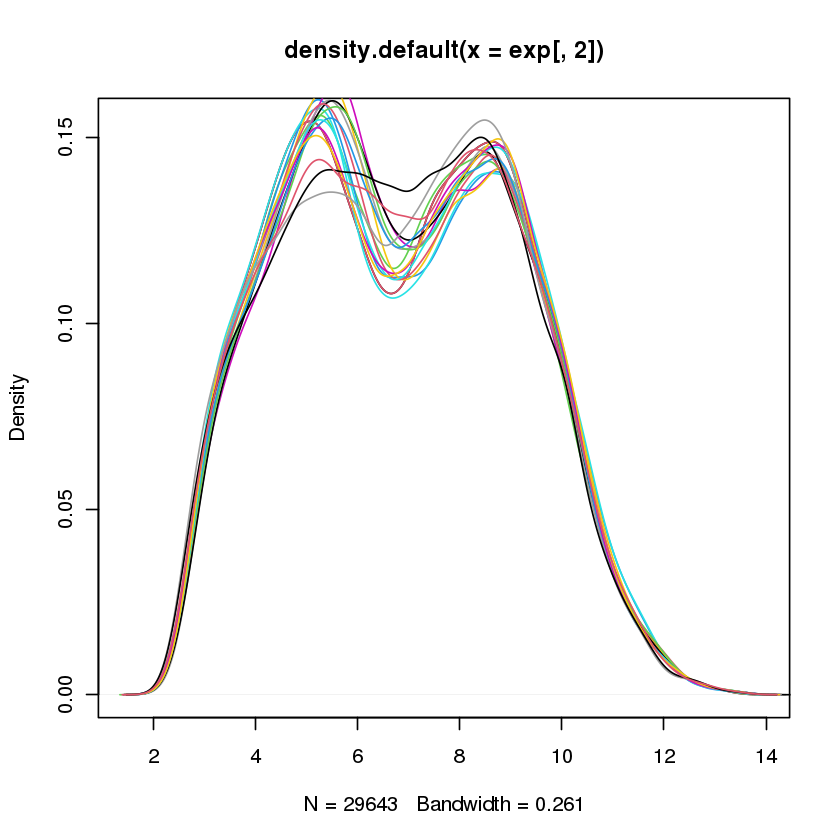

In [20]:
#3. Remove unexpressed genes and normalize data
#Density plot
plot(density(exp[,2]))
for (i in 2:ncol(data)){
  lines(density(exp[,i]), col=i)
}

In [17]:
?scale

In [20]:
#A) Remove unexpressed genes (for RNA-seq)
# library(edgeR)
# reads_thresh <- 11
# percentage_thresh <- 0.5
# r <- apply(exprs(data),1,function(x){sum(x>=reads_thresh)})>=ncol(data)*percentage_thresh
#table(r)
#density(data[r,])
#data_filtered <- data[r,]

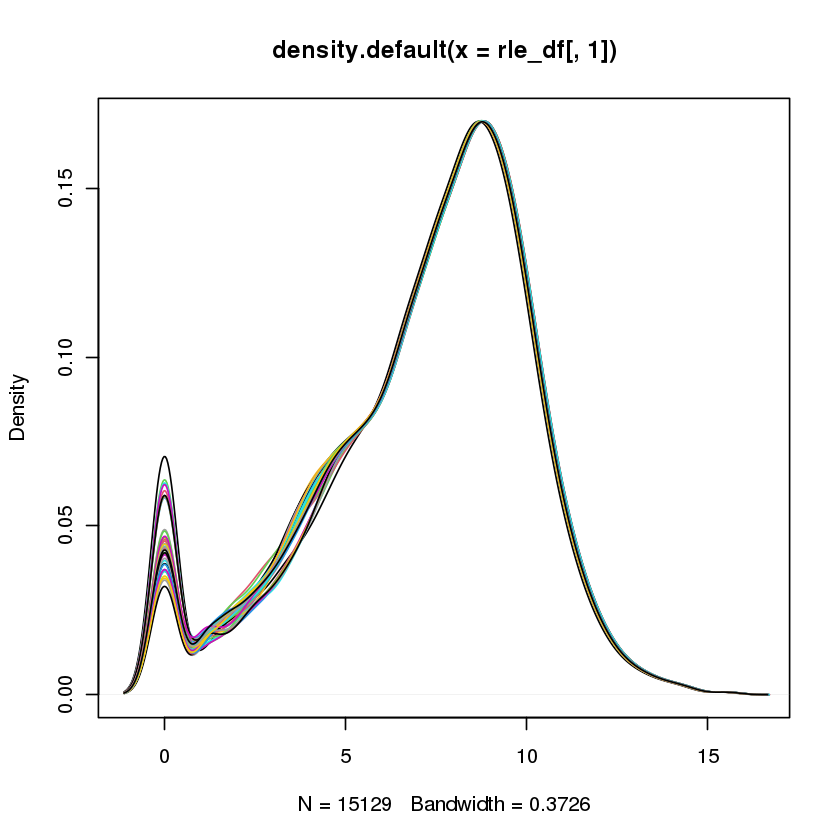

In [32]:
plot(density(rle_df[,1]))
for (i in 2:ncol(rle_df)){
  lines(density(rle_df[,i]), col=i)
}

In [42]:
#B) Log-transform data
#In our case data is already log-transformed
#exprs(data) <- log2(exprs(data)+1)

In [ ]:
#C) Perform sample normalzation 
#scaling and quantile normalization - for microarray;
#RLE or TMM - for RNAseq

In [61]:
#RNA seq fast block
df <- read.csv('Data/GSE103979/GSE103979_data.csv', )
labels <- df[, 2:3]
df <- df[, 4:length(df)]

#A) Remove unexpressed genes (for RNA-seq)
reads_thresh <- 11
percentage_thresh <- 0.5
r <- apply(df, 1, function(x){sum(x>=reads_thresh)})>=ncol(df)*percentage_thresh
df_filtered <- df[r,]
labels_filtered <- labels[r,]

#C) Perform sample normalzation 
rle_df <- log2(RLE_normalization(df_filtered) + 1)
norm_df <- cbind(labels_filtered, rle_df)

write.csv(norm_df, 'Data/GSE103979/GSE103979_data_norm.csv')

In [60]:
norm_df

,ensg,name,GSM2787321,GSM2787269,GSM2787295,GSM2787270,GSM2787296,GSM2787271,GSM2787297,GSM2787272,⋯,GSM3381672,GSM3381673,GSM3381674,GSM3381675,GSM3381676,GSM3381677,GSM3381678,GSM3381679,GSM3381680,GSM3381681
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000046791,Riox1,7.186861,6.864505,7.129571,6.797854,7.217842,6.948126,6.242730,6.939503,⋯,6.917903,6.899912,7.459735,7.118135,7.018650,6.723890,7.975007,7.476840,7.119928,7.213834
2,ENSMUSG00000079083,Jrkl,8.395719,8.242134,8.328545,8.170667,8.108174,7.649415,8.423311,8.195664,⋯,8.591306,8.481586,8.210236,8.076845,7.753791,8.320874,8.148684,8.024693,8.138893,8.046053
3,ENSMUSG00000028581,Laptm5,4.996765,7.344299,6.976014,7.641737,7.546771,7.614825,9.590900,9.475697,⋯,6.945961,7.253411,4.270867,4.348906,7.132260,8.516888,3.770313,3.635542,2.173413,1.117854
4,ENSMUSG00000021692,Dimt1,8.526797,7.984536,7.790016,7.511576,7.649947,7.281564,7.386528,7.683199,⋯,7.793388,7.677255,7.879747,7.824584,7.466644,7.717050,7.843995,7.791577,7.764905,7.693222
6,ENSMUSG00000037601,Nme1,11.550188,9.313771,9.433433,10.999853,10.963728,10.571643,10.294259,10.412898,⋯,9.163119,9.063607,10.921091,10.936100,10.430167,10.232148,10.525111,10.411611,10.327347,10.405287
7,ENSMUSG00000007891,Ctsd,12.150145,12.950500,12.949727,13.504057,13.608579,13.416817,14.380151,14.238570,⋯,12.960849,12.957063,13.498320,13.493040,13.406220,13.812748,12.373464,12.467809,12.092939,12.092866
8,ENSMUSG00000013236,Ptprs,10.039691,11.212384,11.192854,10.575852,10.577569,11.381006,11.399817,10.721411,⋯,11.378180,11.339219,10.653431,10.679577,11.350984,11.224551,10.991320,10.982026,11.244279,11.219638
9,ENSMUSG00000029062,Cdk11b,10.643253,10.112109,10.080271,10.002174,10.173709,10.156546,10.113009,10.133752,⋯,10.231905,10.177386,10.102332,10.184443,10.089244,10.195403,10.127180,10.152415,10.169177,10.174958
10,ENSMUSG00000047648,Fbxo30,9.275115,9.250958,9.236162,8.930747,8.972544,9.144230,8.492535,8.653753,⋯,9.305276,9.370227,9.103644,9.043335,9.313029,8.791439,8.876575,8.882155,8.971220,8.880918


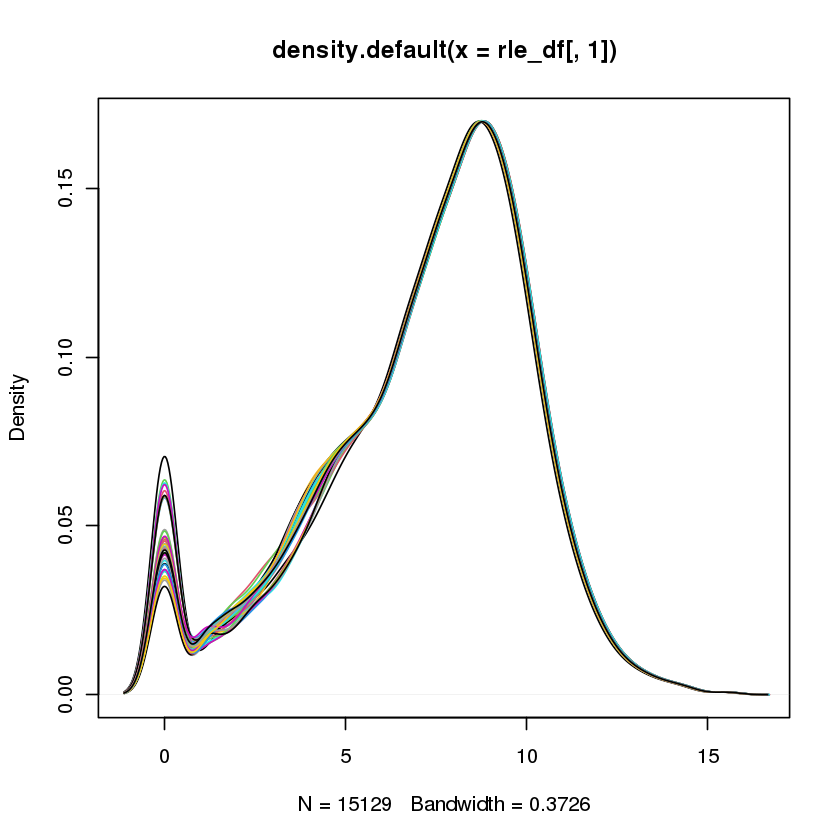

In [46]:
plot(density(rle_df[,1]))
for (i in 2:ncol(rle_df)){
  lines(density(rle_df[,i]), col=i)
}

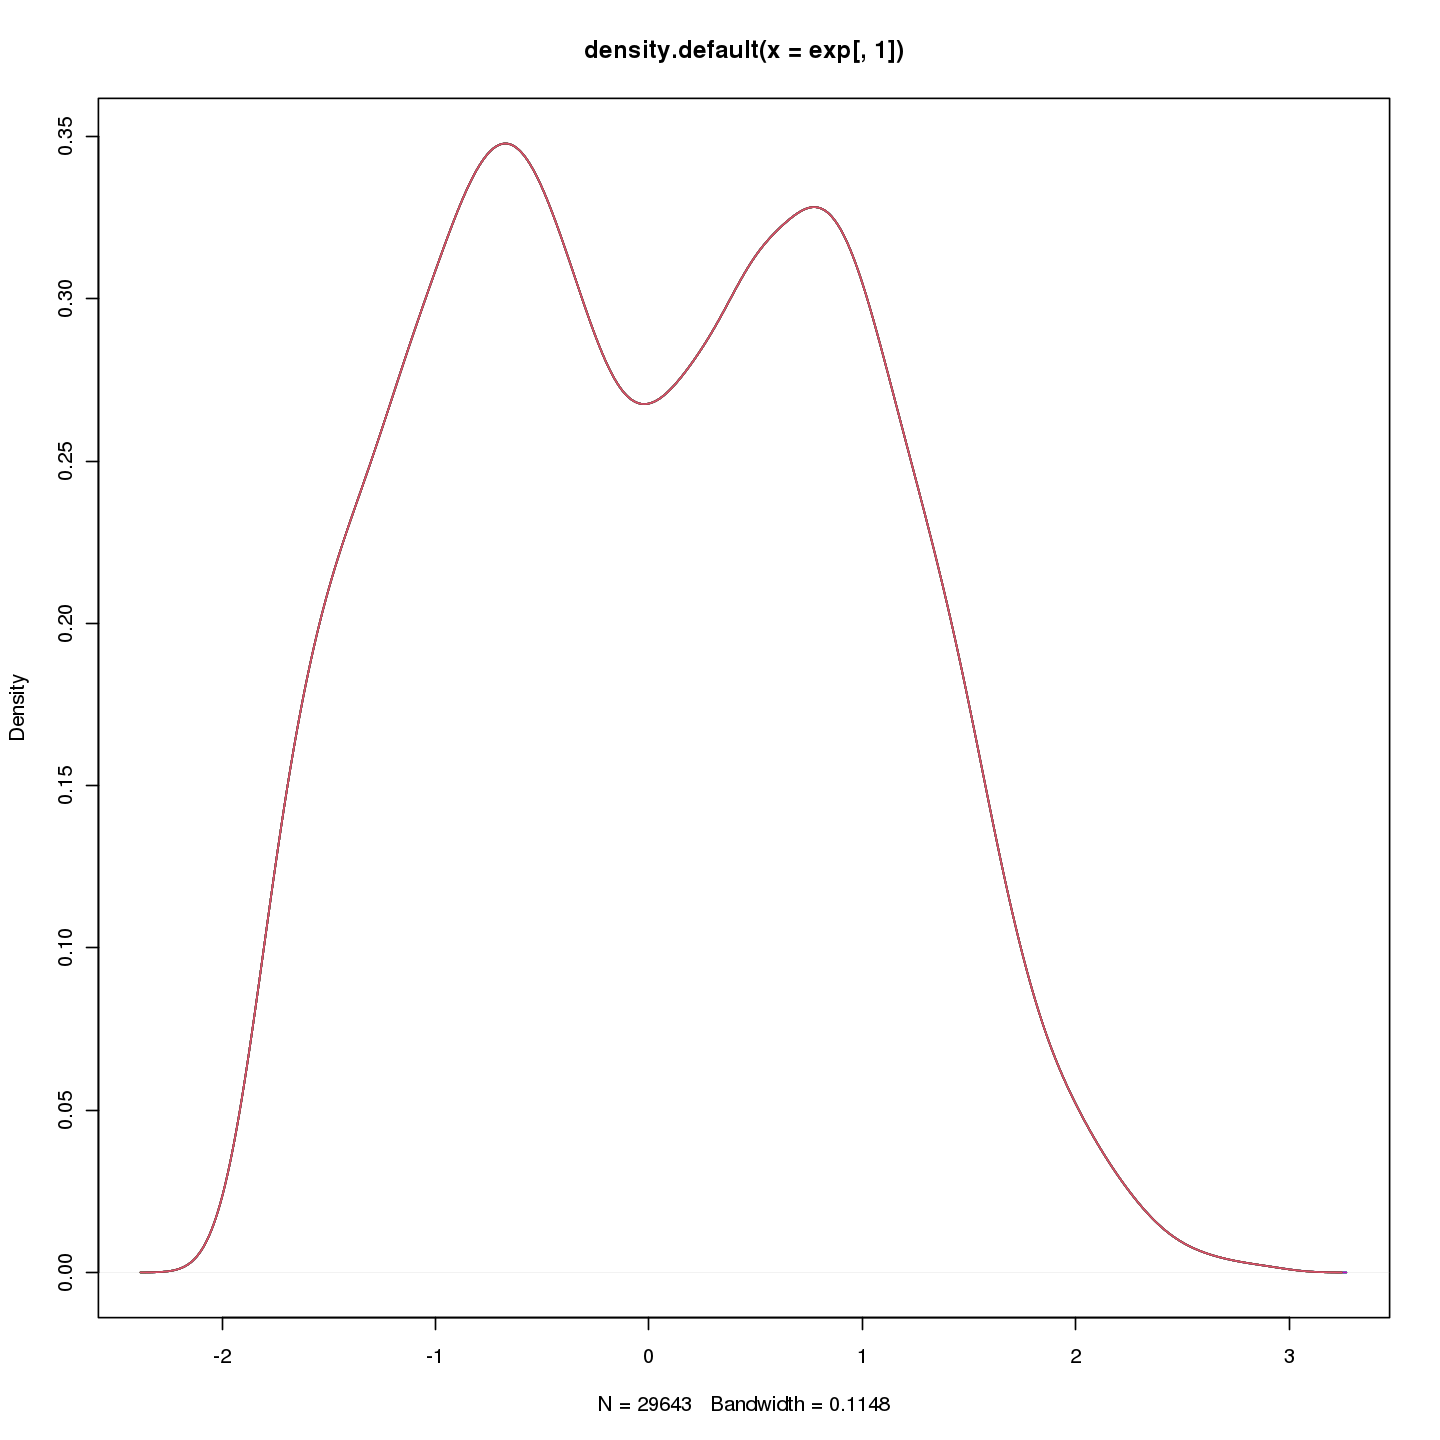

In [66]:
exp <- scale(exp)
exp <- log2(normalize.quantiles.robust(2^exp, remove.extreme="both", n.remove=2))

plot(density(exp[,1]))
for (i in 2:ncol(exp)){
    lines(density(exp[,i]),col=i)
}

In [67]:
#4. Clustering
#A) PCA
library(rgl)
#Specify names of columns corresponding to different interventions
colnames(pheno)

[1] "title"                   "geo_accession"          
 [3] "status"                  "submission_date"        
 [5] "last_update_date"        "type"                   
 [7] "channel_count"           "source_name_ch1"        
 [9] "organism_ch1"            "characteristics_ch1"    
[11] "characteristics_ch1.1"   "characteristics_ch1.2"  
[13] "growth_protocol_ch1"     "molecule_ch1"           
[15] "extract_protocol_ch1"    "label_ch1"              
[17] "label_protocol_ch1"      "taxid_ch1"              
[19] "hyb_protocol"            "scan_protocol"          
[21] "description"             "data_processing"        
[23] "platform_id"             "contact_name"           
[25] "contact_email"           "contact_institute"      
[27] "contact_address"         "contact_city"           
[29] "contact_zip/postal_code" "contact_country"        
[31] "supplementary_file"      "data_row_count"         
[33] "cell type:ch1"           "day:ch1"                
[35] "genotype:ch1"

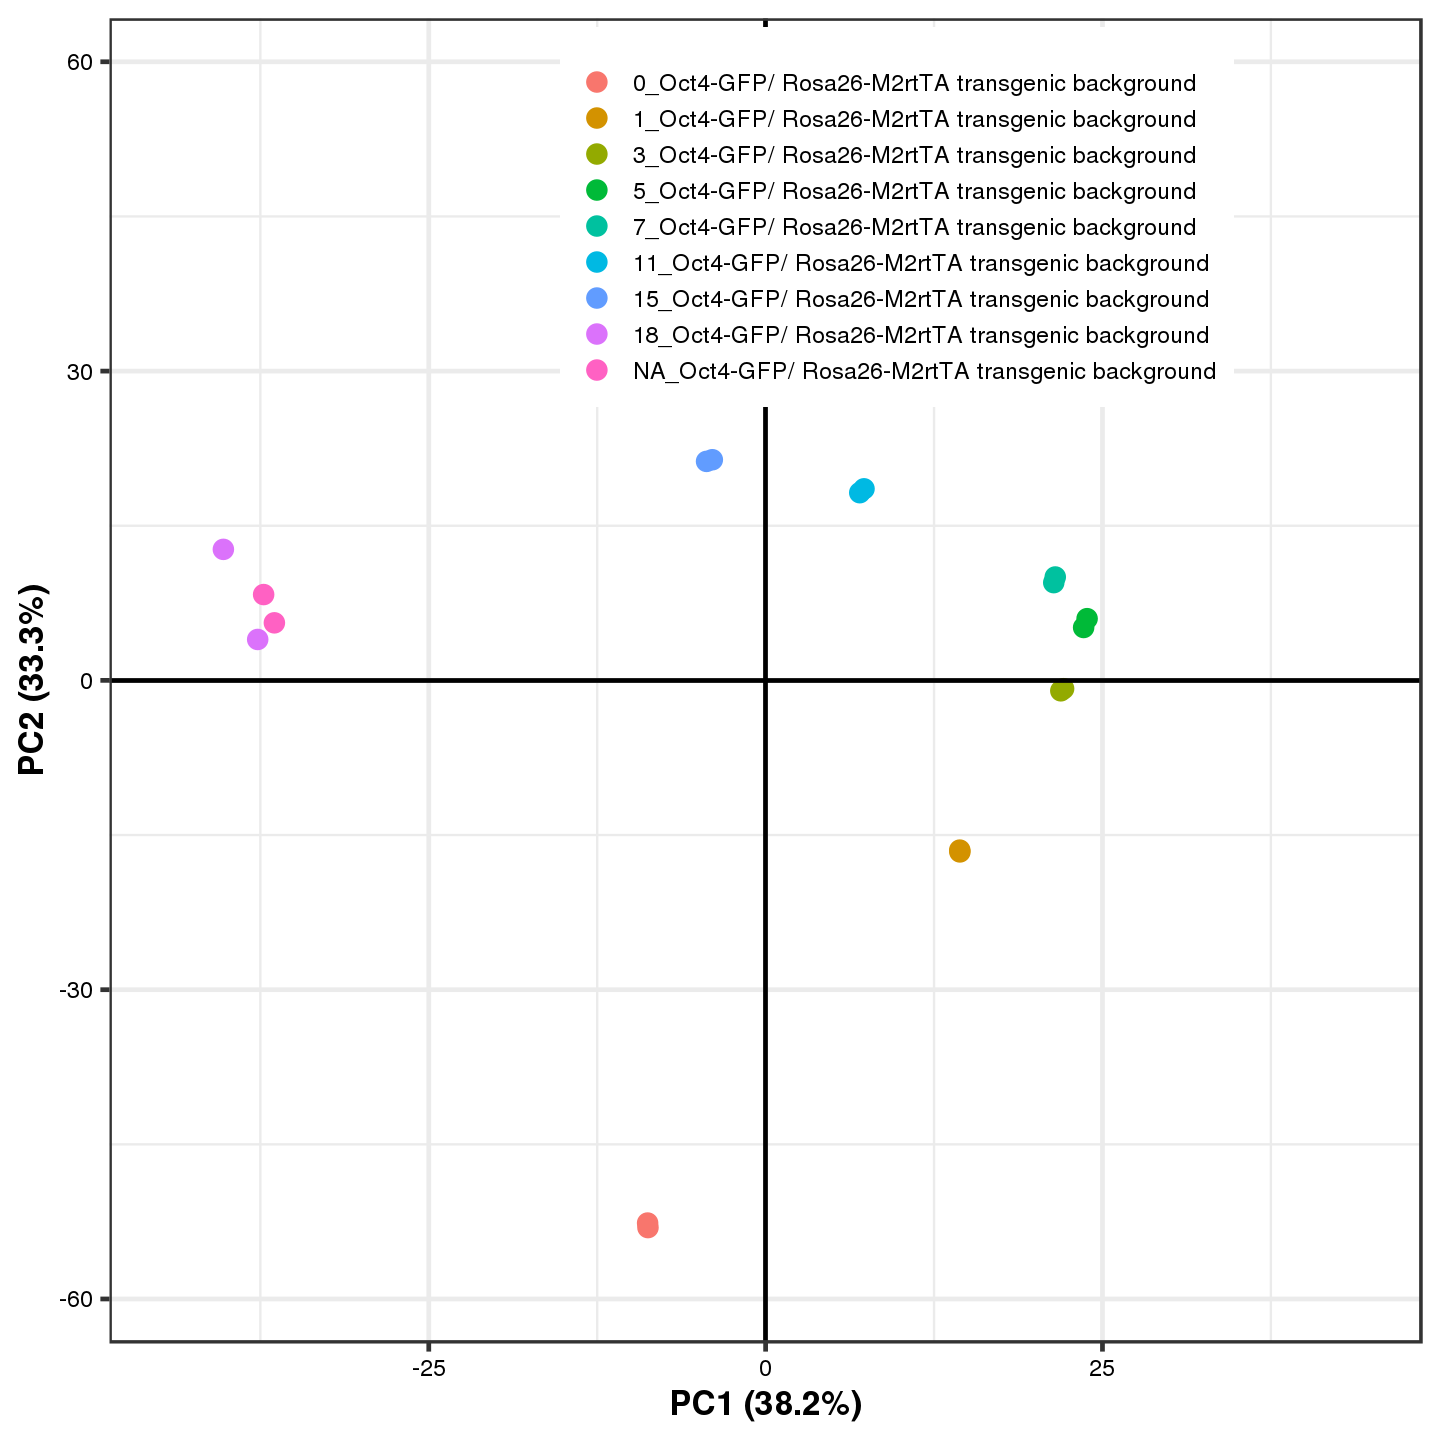

In [68]:
group_factors <- c("day:ch1", 'genotype:ch1')

pheno_groups <- apply(pheno[,group_factors], 1, 
                      function(x){factor(paste(as.character(x), collapse="_"))})
temp <- exp
pca_model <- prcomp(t(temp), scale=F)
variance_explained <- pca_model$sdev^2/sum(pca_model$sdev^2)*100 #Convert to percents

library(ggplot2)
options(repr.plot.width=12,repr.plot.height=12)
ggplot(data=as.data.frame(pca_model$x[,1:2]),aes(PC1,PC2))+
  geom_point(aes(colour=pheno_groups),size=5)+
  theme_bw(base_size = 22)+
  geom_hline(yintercept = 0,lwd=1,lty=1)+
  geom_vline(xintercept = 0,lwd=1,lty=1)+
  scale_y_continuous(limits=c(-max(abs(pca_model$x[,2]))*1.1,max(abs(pca_model$x[,2]))*1.1))+
  scale_x_continuous(limits=c(-max(abs(pca_model$x[,1]))*1.1,max(abs(pca_model$x[,1]))*1.1))+
  labs(x=paste0("PC1 (",round(variance_explained[1],1),"%)"),
       y=paste0("PC2 (",round(variance_explained[2],1),"%)"))+
  theme(legend.position = c(0.6, 0.85),
        legend.justification = c(0.5, 0.5),
        axis.text.x = element_text(angle = 0, hjust = 0.5, size=14,colour="black"),
        axis.text.y = element_text(size=14,colour="black"),
        axis.title=element_text(size=20,face = "bold"),
        title=element_text(size=20),
        legend.title=element_blank(),
        legend.text = element_text(size=14),
        legend.key.size = unit(1.5, 'lines'),
        plot.title = element_text(hjust=0.5))

#Nice separation

In [55]:
#5. Translate gene IDs to Entrez IDs and run diff expression analysis
#A) First, we need to find annotation for microarray IDs translating them to Entrez IDs
head(fData(data))

,ID,GB_ACC,Description
,<chr>,<chr>,<chr>
NM_001001130.2_at,NM_001001130.2_at,NM_001001130.2,"Mus musculus zinc finger protein 85, related sequence 1 (Zfp85-rs1), mRNA"
NM_001001144.3_at,NM_001001144.3_at,NM_001001144.3,"Mus musculus SREBF chaperone (Scap), transcript variant 1, mRNA"
NM_001001152.2_at,NM_001001152.2_at,NM_001001152.2,"Mus musculus zinc finger protein 458 (Zfp458), mRNA"
NM_001001160.2_at,NM_001001160.2_at,NM_001001160.2,"Mus musculus F-box protein 41 (Fbxo41), mRNA"
NM_001001176.2_at,NM_001001176.2_at,NM_001001176.2,"Mus musculus TAF9B RNA polymerase II, TATA box binding protein (TBP)-associated factor (Taf9b), transcript variant 2, mRNA"
NM_001001177.2_at,NM_001001177.2_at,NM_001001177.2,"Mus musculus cDNA sequence BC051142 (BC051142), transcript variant 1, mRNA"


In [69]:
#rewrite exp data
exprs(data) <- exp

In [74]:
#There is no Entrez ID annotation in this data. Will add it manually using the platform annotation
map = fData(data) # annotation, see '?fData'
map_new <- matrix(nrow=nrow(map), ncol=2)
map_new <- as.data.frame(map_new)
colnames(map_new) <- c("probe ID", "ENTREZ")
map_new[,1] <- rownames(map)
rownames(map_new) <- map_new[,1]
dim(map_new)

[1] 29643     2

In [75]:
library(mogene10sttranscriptcluster.db)
for (i in 1:nrow(map_new))
{
  temp_entrez <- paste(mogene10sttranscriptclusterENTREZID[[rownames(map_new)[i]]],
                       collapse=" /// ")
  map_new[i,2] <- temp_entrez
}
identical(rownames(map_new),rownames(map))

[1] TRUE

In [97]:
fData(data_norm)$Entrez <- as.character(map_new$ENTREZ)
head(fData(data_norm)[fData(data_norm)$Entrez!="NA",])
sum(map_new$ENTREZ!="NA")
#For 22088 microarray IDs Entrez ID was identified

,ID,GB_LIST,SPOT_ID,seqname,RANGE_GB,RANGE_STRAND,RANGE_START,RANGE_STOP,total_probes,gene_assignment,mrna_assignment,category,Entrez
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
10344624,10344624,"NM_008866,XM_006495471,AK050549,AK167231,BC013536,BC052848,CT010201,U89352,AK016021,AK034851",chr1:4807862-4846736,chr1,NC_000067.6,+,4807862,4846736,23,NM_008866 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// XM_006495471 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// ENSMUST00000027036 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// ENSMUST00000115529 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// ENSMUST00000131119 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// ENSMUST00000137887 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// ENSMUST00000150971 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// ENSMUST00000155020 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// AK050549 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// AK167231 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// BC013536 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// BC052848 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// CT010201 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// U89352 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// ENSMUST00000134384 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// ENSMUST00000119612 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// ENSMUST00000141278 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// AK016021 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777 /// AK034851 // Lypla1 // lysophospholipase 1 // 1 A1|1 // 18777,"NM_008866 // RefSeq // Mus musculus lysophospholipase 1 (Lypla1), mRNA. // chr1 // 100 // 100 // 23 // 23 // 0 /// XM_006495471 // RefSeq // PREDICTED: Mus musculus lysophospholipase 1 (Lypla1), transcript variant X1, mRNA. // chr1 // 95 // 87 // 19 // 20 // 0 /// ENSMUST00000027036 // ENSEMBL // ensembl_havana_transcript:known chromosome:GRCm38:1:4807823:4846739:1 gene:ENSMUSG00000025903 gene_biotype:protein_coding transcript_biotype:protein_coding // chr1 // 100 // 100 // 23 // 23 // 0 /// ENSMUST00000115529 // ENSEMBL // havana:novel chromosome:GRCm38:1:4807911:4845352:1 gene:ENSMUSG00000025903 gene_biotype:protein_coding transcript_biotype:protein_coding // chr1 // 94 // 74 // 16 // 17 // 0 /// ENSMUST00000131119 // ENSEMBL // havana:putative chromosome:GRCm38:1:4808237:4841093:1 gene:ENSMUSG00000025903 gene_biotype:protein_coding transcript_biotype:protein_coding // chr1 // 100 // 74 // 17 // 17 // 0 /// ENSMUST00000137887 // ENSEMBL // havana:novel chromosome:GRCm38:1:4807898:4840969:1 gene:ENSMUSG00000025903 gene_biotype:protein_coding transcript_biotype:protein_coding // chr1 // 95 // 83 // 18 // 19 // 0 /// ENSMUST00000150971 // ENSEMBL // havana:putative chromosome:GRCm38:1:4807918:4841286:1 gene:ENSMUSG00000025903 gene_biotype:protein_coding transcript_biotype:protein_coding // chr1 // 100 // 87 // 20 // 20 // 0 /// ENSMUST00000155020 // ENSEMBL // havana:known chromosome:GRCm38:1:4807892:4886770:1 gene:ENSMUSG00000025903 gene_biotype:protein_coding transcript_biotype:nonsense_mediated_decay // chr1 // 100 // 74 // 17 // 17 // 0 /// AK050549 // GenBank HTC // Mus musculus adult pancreas islet cells cDNA, RIKEN full-length enriched library, clone:C820014D19 product:lysophospholipase 1, full insert sequence. // chr1 // 100 // 87 // 20 // 20 // 0 /// AK167231 // GenBank HTC // Mus musculus blastocyst blastocyst cDNA, RIKEN full-length enriched library, clone:I1C0043L13 product:lysophospholipase 1, full insert sequence. // chr1 // 91 // 100 // 21 // 23 // 0 /// BC013536 // GenBank // Mus musculus lysophospholipase 1, mRNA (cDNA clone MGC:19218 IMAGE:4240573), complete cds. // chr1 // 100 // 100 // 23 // 23 // 0 /// BC052848 // GenBank // Mus musculus lysophospholipase 1, mRNA (cDNA clone MGC:60679 IMAGE:30055025), complete cds. // chr1 // 96 /

[1] 22071

In [82]:
colnames(pheno)

[1] "title"                   "geo_accession"          
 [3] "status"                  "submission_date"        
 [5] "last_update_date"        "type"                   
 [7] "channel_count"           "source_name_ch1"        
 [9] "organism_ch1"            "characteristics_ch1"    
[11] "characteristics_ch1.1"   "characteristics_ch1.2"  
[13] "growth_protocol_ch1"     "molecule_ch1"           
[15] "extract_protocol_ch1"    "label_ch1"              
[17] "label_protocol_ch1"      "taxid_ch1"              
[19] "hyb_protocol"            "scan_protocol"          
[21] "description"             "data_processing"        
[23] "platform_id"             "contact_name"           
[25] "contact_email"           "contact_institute"      
[27] "contact_address"         "contact_city"           
[29] "contact_zip/postal_code" "contact_country"        
[31] "supplementary_file"      "data_row_count"         
[33] "cell type:ch1"           "day:ch1"                
[35] "genotype:ch1"

In [92]:
#B) Diff expression analysis
#We want to find MYC deficiency associated gene expression changes for both ages

#Specify factors corresponding to control group
print(levels(pheno))
pheno_dataframe <- data.frame(ID=colnames(data))
rownames(pheno_dataframe) <- pheno_dataframe$ID
pheno_dataframe$Group <- as.character(pheno[,'genotype:ch1'])
pheno_dataframe$Age <- as.character(pheno[,'day:ch1'])
control_group <- "Wild type"

#source(paste0(function_path, "FUN.Update_data_for_association_test.R"))
new_data <- list()
limma_output <- Update_data_for_association_test(data_list = new_data, data_norm = data,
                                         phenodata=pheno,
                                         group_col='genotype:ch1',control_group=control_group,
                                         batch_col='day:ch1', type="microarray",
                                         current_gse=current_gse,
                                         function_path=function_path)

NULL
[1] "There were 29643 probes"
[1] "There are 0 probes with Entrez IDs"
[1] "Initial number of probes:"
Features 
       0 
[1] "Number of probes with Entrez ID:"
Features 
       0 


ERROR: Error in `[.data.frame`(fData(dataset_Entrez)[, index], i): undefined columns selected


In [109]:
head(limma_output[[1]])

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,PValue,FDR,SE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100009600,0.014851713,-0.06431845,0.09402188,-0.6884099,0.4034126,0.6929084,0.9011394,-6.356112,0.6929084,0.9011394,0.04039294
100009609,0.007838625,-0.05240196,0.06807921,-1.5175006,0.2798241,0.7838184,0.9357229,-6.399906,0.7838184,0.9357229,0.03073499
100009614,0.012675629,-0.07060177,0.09595302,-0.1396748,0.3273232,0.7484014,0.9215536,-6.384918,0.7484014,0.9215536,0.04248847
100012,0.022998720,-0.07083666,0.11683410,-1.0072004,0.5270739,0.6066237,0.8642852,-6.296877,0.6066237,0.8642852,0.04787519
100017,0.010134021,-0.04407833,0.06434638,0.8566794,0.4019925,0.6939286,0.9015608,-6.356704,0.6939286,0.9015608,0.02765936
100019,-0.009034523,-0.07757420,0.05950515,0.1109606,-0.2834638,0.7810856,0.9345328,-6.398839,0.7810856,0.9345328,0.03496922


In [110]:
#C) Add gene symbols and sort by adjusted p-value
library(annotate)
library(org.Mm.eg.db)
for (i in names(limma_output)){
  limma_output[[i]]$Gene_symbol <- getSYMBOL(rownames(limma_output[[i]]),
                                             data="org.Mm.eg")[rownames(limma_output[[i]])]
  limma_output[[i]] <- limma_output[[i]][order(limma_output[[i]]$adj.P.Val,decreasing = F),]
}
head(limma_output[[1]])

Loading required package: XML



,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,PValue,FDR,SE,Gene_symbol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
14311,0.6946925,0.6338913,0.7554936,0.4740983,24.57059,1.132217e-12,2.297834e-08,15.990882,1.132217e-12,2.297834e-08,0.03102097,Cidec
12683,0.6076228,0.5077523,0.7074933,-0.1756197,13.08372,4.268581e-09,4.331543e-05,10.625566,4.268581e-09,4.331543e-05,0.05095434,Cidea
68680,0.2427788,0.1989850,0.2865726,1.9113623,11.92154,1.377041e-08,7.173179e-05,9.677550,1.377041e-08,7.173179e-05,0.02234378,Fitm1
76574,0.2894997,0.2371680,0.3418314,1.7265552,11.89645,1.413783e-08,7.173179e-05,9.655805,1.413783e-08,7.173179e-05,0.02669986,Mfsd2a
216227,0.3101988,0.2513707,0.3690270,0.3224198,11.33938,2.568133e-08,7.486587e-05,9.158037,2.568133e-08,7.486587e-05,0.03001436,Slc17a8
21786,-0.3295287,-0.3920502,-0.2670071,0.5934711,-11.33438,2.582218e-08,7.486587e-05,9.153434,2.582218e-08,7.486587e-05,0.03189875,Tff3


In [111]:
FDR_thresh <- 0.05
sum(limma_output[[1]]$adj.P.Val<FDR_thresh)
#373 genes are differentially expressed in response to MYC deficiency 
#regardless of age (both in young and old mice)

[1] 373

# Homework exercise

In [120]:
write.csv(limma_output, './test/limma_out1.csv')

In [112]:
##################################################
#1) Identify differentially expressed genes between Wild type and MYC deficiency 
#separately for young and old mice

In [ ]:
#Specify factors corresponding to control group
print(levels(pheno_groups))
pheno_dataframe <- data.frame(ID=colnames(data_norm))
rownames(pheno_dataframe) <- pheno_dataframe$ID
pheno_dataframe$Group <- as.character(data_norm$Group)
pheno_dataframe$Age <- as.character(data_norm$Age)
control_group <- "Wild type"

In [138]:
young_pheno_data <- pheno_dataframe[pheno_dataframe$Age == "5 months", ]
old_pheno_data <- pheno_dataframe[pheno_dataframe$Age == "24 months", ]

In [142]:
#young
new_data <- list()
young_limma_output <- Update_data_for_association_test(data_list = new_data, data_norm = data_norm,
                                         phenodata=young_pheno_data,
                                         group_col="Group", control_group=control_group,
                                         batch_col="", type="microarray",
                                         current_gse=current_gse,
                                         function_path=function_path)

[1] "There were 35556 probes"
[1] "There are 35556 probes with Entrez IDs"
[1] "Initial number of probes:"
Features 
   35556 
[1] "Number of probes with Entrez ID:"
Features 
   35556 
[1] "Library 1 is created. "
[1] "Library 2 is created. "
[1] "Total number of Entrez IDs:"
[1] 20295
[1] 20295
[1] 20295


In [145]:
head(young_limma_output[[1]])
sum(young_limma_output[[1]]$adj.P.Val<FDR_thresh)

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,PValue,FDR,SE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100009600,-0.010842065,-0.14503030,0.12334617,-0.67672974,-0.1903147,0.85436294,0.9526065,-6.491830,0.85436294,0.9526065,0.06846339
100009609,-0.007797616,-0.09020335,0.07460811,-1.52151121,-0.2228841,0.82987061,0.9442890,-6.484371,0.82987061,0.9442890,0.04204374
100009614,-0.024871041,-0.10920413,0.05946204,-0.09124442,-0.6946574,0.50924555,0.8055447,-6.251744,0.50924555,0.8055447,0.04302708
100012,0.057964220,-0.05136290,0.16729134,-0.97687510,1.2488399,0.25112745,0.6444513,-5.727066,0.25112745,0.6444513,0.05577914
100017,0.015212088,-0.07656497,0.10698914,0.90774823,0.3904176,0.70761937,0.8970367,-6.427881,0.70761937,0.8970367,0.04682503
100019,0.062614096,-0.01003964,0.13526783,0.07735758,2.0299663,0.08113989,0.4548989,-4.708191,0.08113989,0.4548989,0.03706823


[1] 69

In [146]:
#old
new_data <- list()
old_limma_output <- Update_data_for_association_test(data_list = new_data, data_norm = data_norm,
                                         phenodata=old_pheno_data,
                                         group_col="Group",control_group=control_group,
                                         batch_col="", type="microarray",
                                         current_gse=current_gse,
                                         function_path=function_path)

[1] "There were 35556 probes"
[1] "There are 35556 probes with Entrez IDs"
[1] "Initial number of probes:"
Features 
   35556 
[1] "Number of probes with Entrez ID:"
Features 
   35556 
[1] "Library 1 is created. "
[1] "Library 2 is created. "
[1] "Total number of Entrez IDs:"
[1] 20295
[1] 20295
[1] 20295


In [147]:
head(old_limma_output[[1]])
sum(old_limma_output[[1]]$adj.P.Val<FDR_thresh)

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,PValue,FDR,SE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100009600,0.040545492,-0.05241208,0.133503063,-0.7000900,0.9795023,0.35172920,0.6660645,-6.612647,0.35172920,0.6660645,0.04742733
100009609,0.023474865,-0.06867328,0.115623007,-1.5134899,0.5720898,0.58060721,0.8278946,-6.937721,0.58060721,0.8278946,0.04701436
100009614,0.050222299,-0.08173286,0.182177460,-0.1881052,0.8547082,0.41384530,0.7172494,-6.728003,0.41384530,0.7172494,0.06732406
100012,-0.011966780,-0.15396693,0.130033369,-1.0375257,-0.1892501,0.85389736,0.9522736,-7.094802,0.85389736,0.9522736,0.07244906
100017,0.005055954,-0.06868366,0.078795564,0.8056106,0.1539749,0.88086626,0.9614489,-7.101431,0.88086626,0.9614489,0.03762225
100019,-0.080683143,-0.16826266,0.006896378,0.1445636,-2.0688448,0.06700833,0.3041678,-5.177747,0.06700833,0.3041678,0.04468343


[1] 1102

In [160]:
young_passed <- rownames(young_limma_output[[1]][young_limma_output[[1]]$adj.P.Val<FDR_thresh,])
old_passed <- rownames(old_limma_output[[1]][old_limma_output[[1]]$adj.P.Val<FDR_thresh, ])

In [165]:
intsec <- intersect(young_passed, old_passed)
intsec
### There are 39 significant genes intersecting in both ages

[1] "100038659" "117167"    "12053"     "12346"     "12683"     "13119"    
 [7] "14245"     "14311"     "14825"     "16592"     "16819"     "16852"    
[13] "17436"     "17748"     "17750"     "18406"     "18407"     "19016"    
[19] "20208"     "20209"     "20210"     "210757"    "216227"    "216233"   
[25] "21786"     "21807"     "22361"     "50914"     "53901"     "55985"    
[31] "64297"     "68680"     "69068"     "71481"     "74087"     "75104"    
[37] "75512"     "76574"     "94071"

In [176]:
nrow(young_limma_output[[1]]) - length(young_passed)

[1] 20226

In [173]:
#2) Check if the overlap of diff expressed genes (adjusted p < 0.05) is 
#significant, using hypergeometric test

phyper(q=length(intsec), 
       m=length(young_passed),
       n=nrow(young_limma_output[[1]]) - length(young_passed),
       k=, 
       lower.tail=T)

[1] 1

phyper(q, m, n, k, lower.tail = TRUE, log.p = FALSE)

x, q vector of quantiles representing the number of white balls drawn
without replacement from an urn which contains both black and white
balls.

m the number of white balls in the urn.

n the number of black balls in the urn.

k the number of balls drawn from the urn.

In [119]:
#3) Compare the overlap of diff expressed genes (adjusted p < 0.05) calculated 
#separately for young and old mice with diff expressed genes (adjusted p < 0.05)
#calculated for both ages simultaneously. Which set of genes is larger?
